In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import wfdb
import seaborn as sns
sns.set_style('whitegrid')

/home/rameshu/anaconda3/envs/ECG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = '/work/ramesh/dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
filename2 = 'preprocess_ptbxl_filename.csv'
df_real = pd.read_csv(base_dir + filename2)
df_real = df_real.query('super_class=="NORM"')
df_real.filename_hr = df_real.filename_hr.apply(lambda x: base_dir+x)
df_real

,ecg_id,sex,super_class,age_group,filename_lr,filename_hr
0,1,1,NORM,50-60,records100/00000/00001_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
1,2,0,NORM,10-20,records100/00000/00002_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
2,3,1,NORM,30-40,records100/00000/00003_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
3,4,0,NORM,20-30,records100/00000/00004_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
4,5,1,NORM,10-20,records100/00000/00005_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
...,...,...,...,...,...,...
27696,21630,0,NORM,70-80,records100/21000/21630_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
27710,21644,0,NORM,40-50,records100/21000/21644_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
27757,21724,0,NORM,60-70,records100/21000/21724_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...
27818,21821,1,NORM,50-60,records100/21000/21821_lr,/work/ramesh/dataset/ptb-xl-a-large-publicly-a...


In [3]:
data = []

for idx in range(len(df_real)):
    path = df_real.iloc[idx, -1]
    ecg = wfdb.rdsamp(path, channel_names=['I','II','V1','V2','V3','V4','V5','V6'])[0]
    ecg = ecg.T
    ecg = torch.from_numpy(ecg)
    fft = torch.abs(torch.fft.rfft2(ecg))**2
    data.append(fft)

In [4]:
datanp = torch.concat(data, dim=0)
torch.save(datanp, 'real_fft.pt')

# Comparision

In [2]:
# load real data 
real_ftp= torch.load('./real_fft.pt')
real_ftp = real_ftp.numpy()
real_ftp.shape

(76224, 2501)

In [3]:
def load_diffusion(path):
    fake_ftp = torch.load(path)
    data = []
    for i in range(0, fake_ftp.shape[0]-12, 12):
        ecg = fake_ftp[i:i+12, :]
        ecg = ecg[(0,1,6,7,8,9,10,11), :]
        data.append(ecg)
    data_ch8 = torch.concat(data, dim=0)
    fake_ftp_np = data_ch8.numpy()
    return fake_ftp_np

In [5]:
def fpt_plot(real, fake, mm, chh, scale=False):
    
    time_step = 1/500 
    freqs = np.fft.rfftfreq(real_ftp.shape[1], time_step)
    idx = np.argsort(freqs)

    plt.figure(figsize=(16, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        ch = real[i::8, :].mean(axis=0)
        plt.plot(freqs[idx], ch.flatten()[idx], label='real')

        ch_f = fake[i::8, :].mean(axis=0)
        plt.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
        if scale:
            plt.yscale('log')
        plt.legend()
    plt.savefig(f'./graphs/ungan/{mm}_{chh}.jpeg')



In [4]:
def fpt_plot_v2(real, fake,model, mm, chh, scale=False):
    
    time_step = 1/500 
    freqs = np.fft.rfftfreq(real_ftp.shape[1], time_step)
    idx = np.argsort(freqs)

    fig = plt.figure(figsize=(16, 8))

    ax = fig.add_subplot(111)

    ax1 = fig.add_subplot(241)
    ch = real[0::8, :].mean(axis=0)
    ax1.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[0::8, :].mean(axis=0)
    ax1.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax1.legend()

    ax2 = fig.add_subplot(242)
    ch = real[1::8, :].mean(axis=0)
    ax2.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[1::8, :].mean(axis=0)
    ax2.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax2.legend()

    ax3 = fig.add_subplot(243)
    ch = real[2::8, :].mean(axis=0)
    ax3.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[2::8, :].mean(axis=0)
    ax3.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax3.legend()

    ax4 = fig.add_subplot(244)
    ch = real[3::8, :].mean(axis=0)
    ax4.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[3::8, :].mean(axis=0)
    ax4.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax4.legend()

    ax5 = fig.add_subplot(245)
    ch = real[4::8, :].mean(axis=0)
    ax5.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[4::8, :].mean(axis=0)
    ax5.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax5.legend()

    ax6 = fig.add_subplot(246)
    ch = real[5::8, :].mean(axis=0)
    ax6.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[5::8, :].mean(axis=0)
    ax6.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax6.legend()

    ax7 = fig.add_subplot(247)
    ch = real[6::8, :].mean(axis=0)
    ax7.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[6::8, :].mean(axis=0)
    ax7.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax7.legend()

    ax8 = fig.add_subplot(248)
    ch = real[7::8, :].mean(axis=0)
    ax8.plot(freqs[idx], ch.flatten()[idx], label='real')
    ch_f = fake[7::8, :].mean(axis=0)
    ax8.plot(freqs[idx], ch_f.flatten()[idx], label='fake')
    ax8.legend() 
    ax.set_xlabel('Frequency (Hz)')
    fig.text(0.06, 0.5, 'Power Spectral - Strength', ha='center', va='center', rotation='vertical')
    plt.savefig(f'./graphs/{model}/{mm}_{chh}.jpeg')

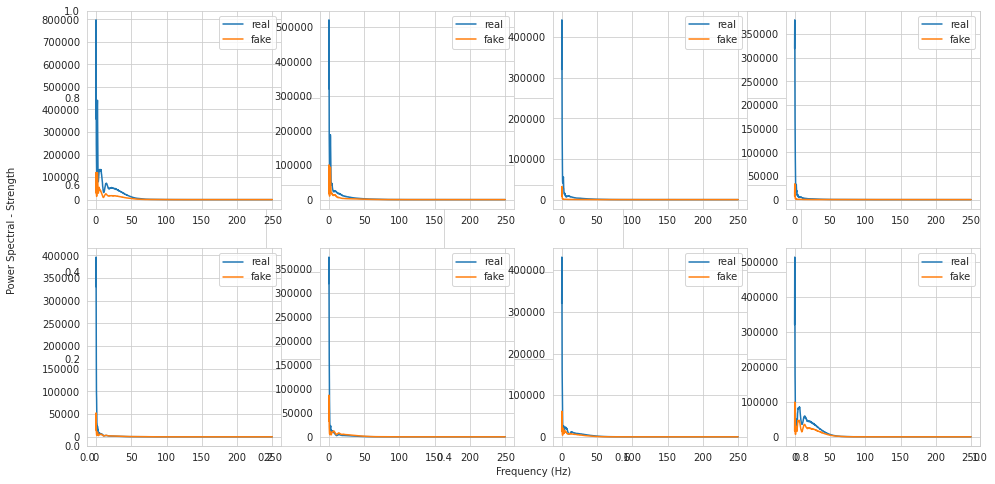

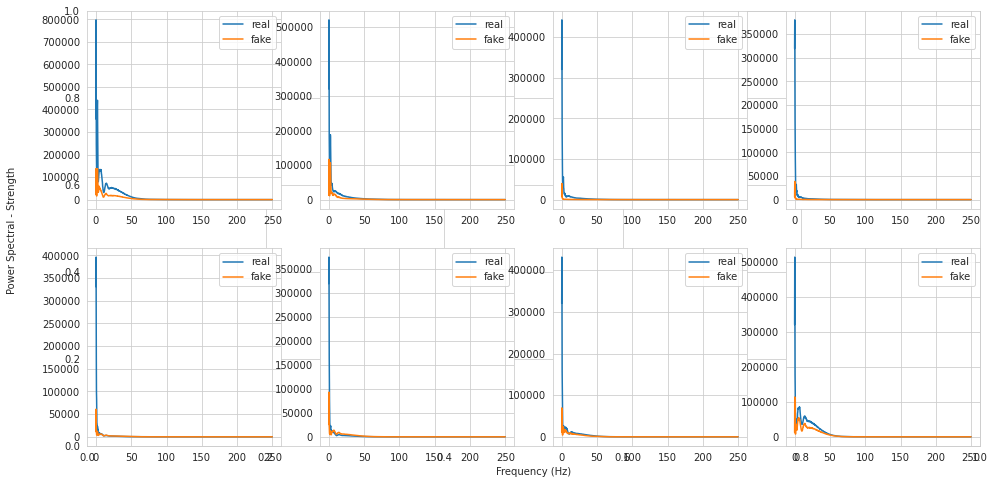

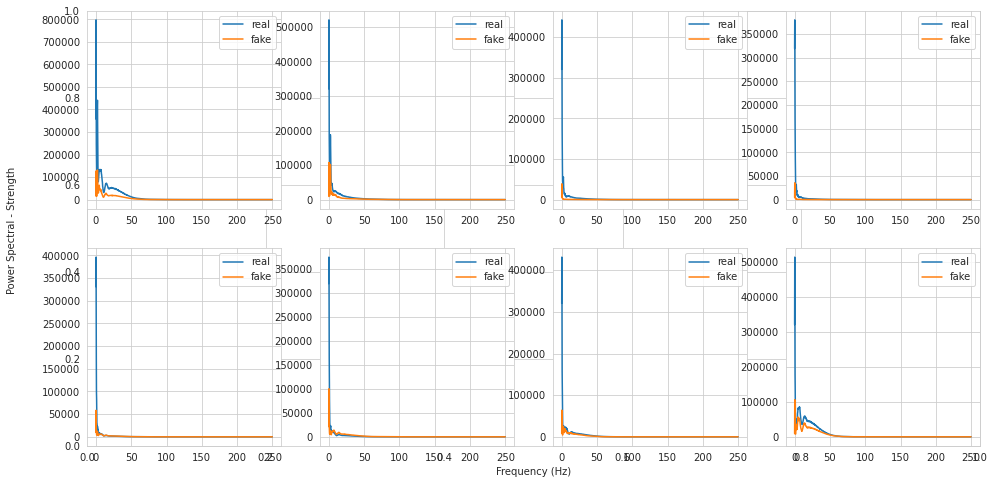

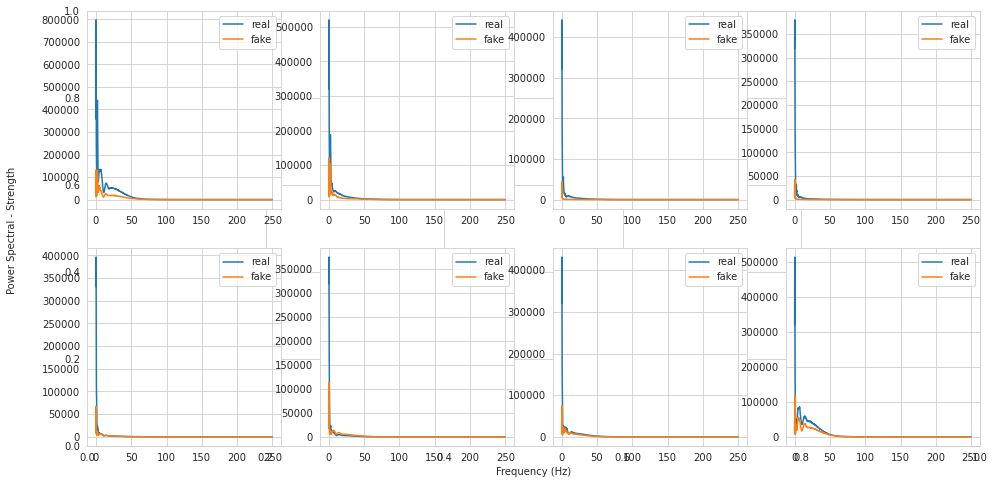

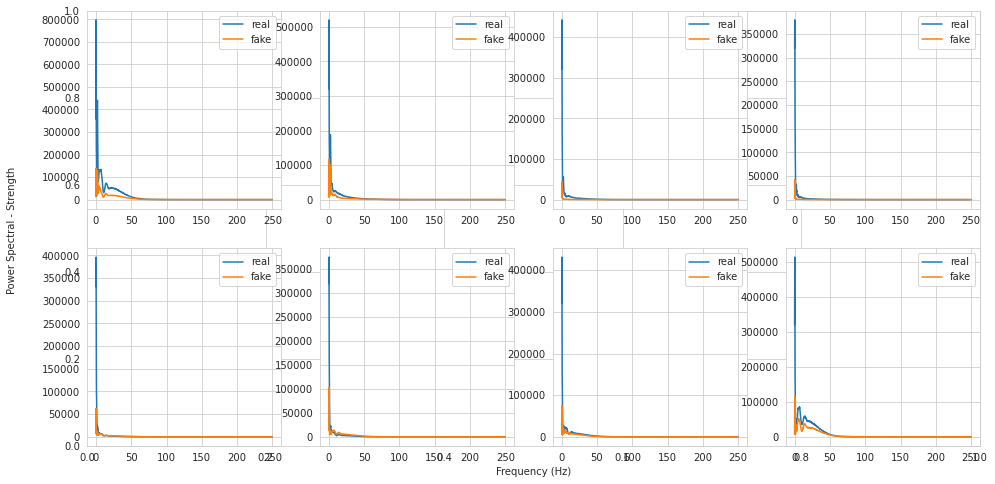

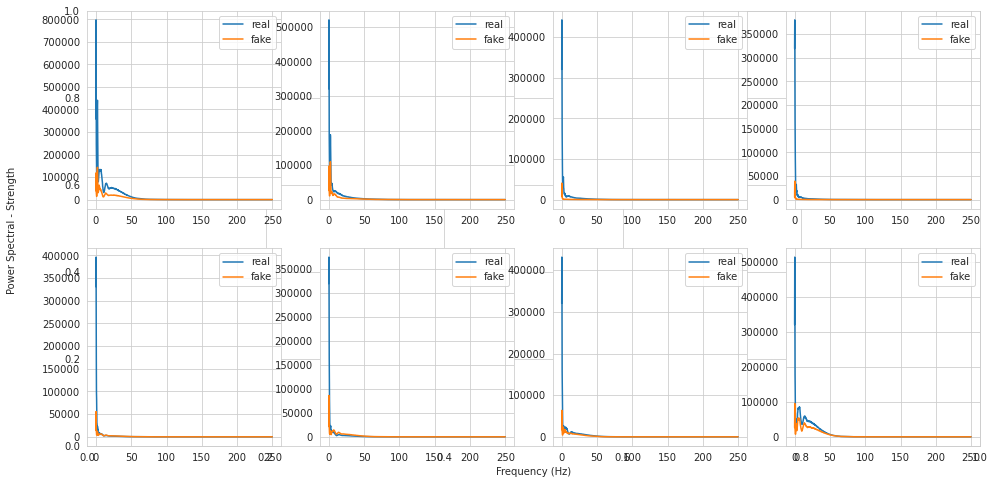

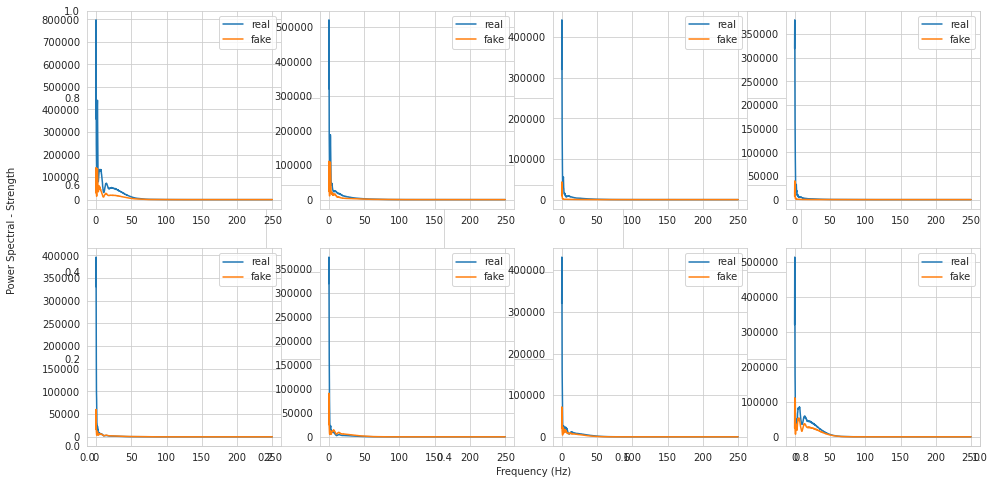

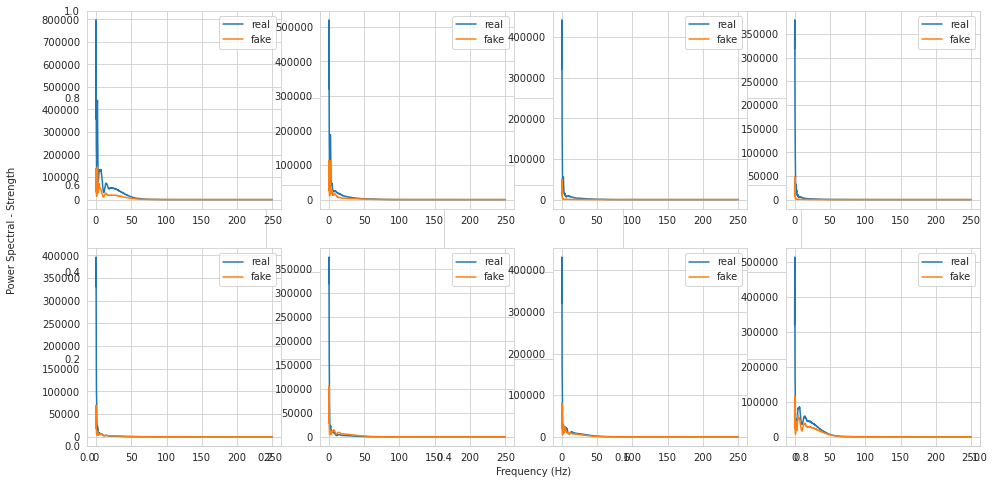

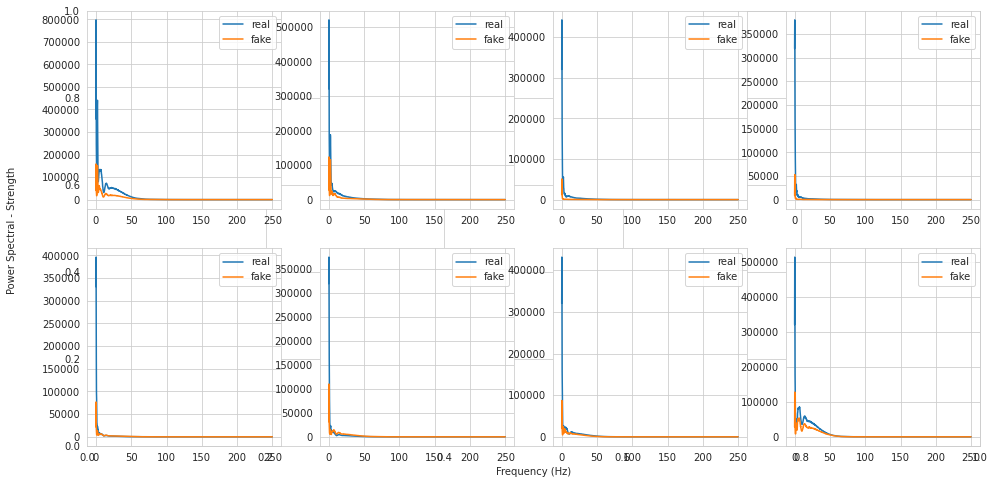

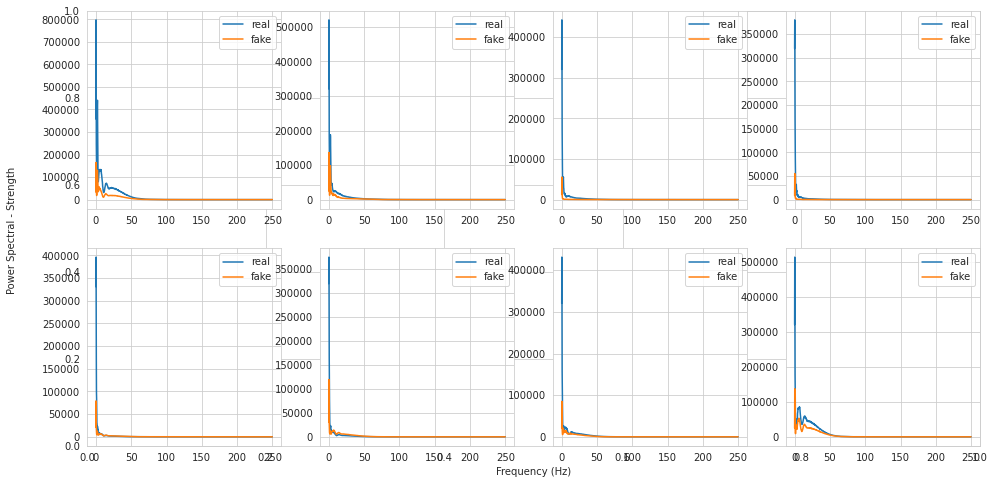

In [5]:
for m in ['ddm', 'cddm']:
    for ch in range(99, 200, 25):
        path= f'/work/ramesh/final_experiment/fft/{m}/{m}_{ch}.pt'
        fake_ftp = load_diffusion(path)
        fpt_plot_v2(real_ftp, fake_ftp, 'diffusion',m, ch)

## percentile check

In [ ]:
def fpt_plot_per2(real, fake, mm, chh, con='25', scale=False):
    
    time_step = 1/500 
    freqs = np.fft.rfftfreq(real_ftp.shape[1], time_step)
    idx = np.argsort(freqs)

    plt.figure(figsize=(16, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        ch_25 = np.percentile(real[i::8, :], [25], axis=0)
        ch_75 = np.percentile(real[i::8, :], [75], axis=0)

        ch_f25 = np.percentile(fake[i::8, :], [25], axis=0)
        ch_f75 = np.percentile(fake[i::8, :], [75], axis=0)


        if con=='both':
            plt.plot(freqs[idx], ch_25.flatten()[idx], label='real_p25')
            plt.plot(freqs[idx], ch_75.flatten()[idx], label='real_p75')

            plt.plot(freqs[idx], ch_f25.flatten()[idx], label='fake_p25')
            plt.plot(freqs[idx], ch_f75.flatten()[idx], label='fake_p75')

        elif con=='25':
            plt.plot(freqs[idx], ch_25.flatten()[idx], label='real_p25')
            plt.plot(freqs[idx], ch_f25.flatten()[idx], label='fake_p25')
        else:
            plt.plot(freqs[idx], ch_75.flatten()[idx], label='real_p75')
            plt.plot(freqs[idx], ch_f75.flatten()[idx], label='fake_p75')
            
    if scale:
        plt.yscale('log')
    plt.legend()
    plt.savefig(f'./graphs/{con}_{mm}_{chh}.png')

# GAN

In [4]:
def load_gan(path):
    fake_ftp = torch.load(path)
    fake_ftp_np = fake_ftp.numpy()
    return fake_ftp_np

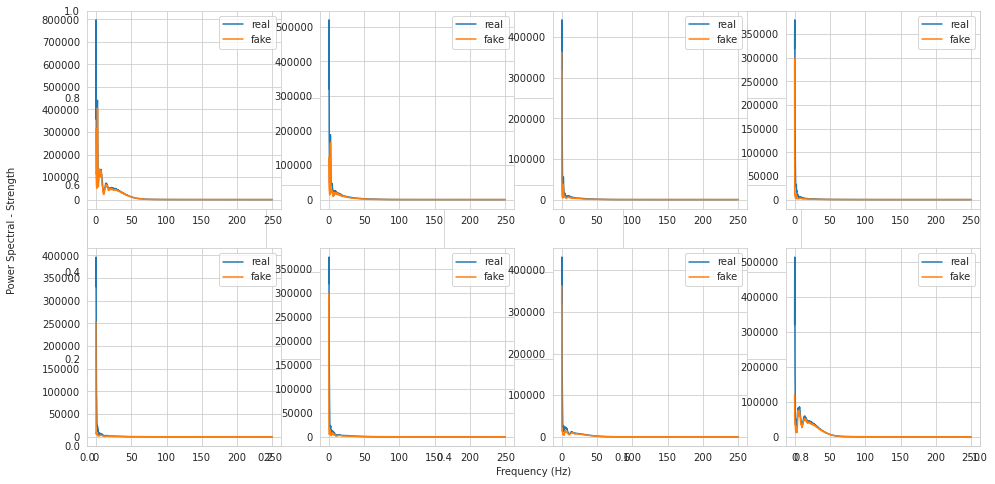

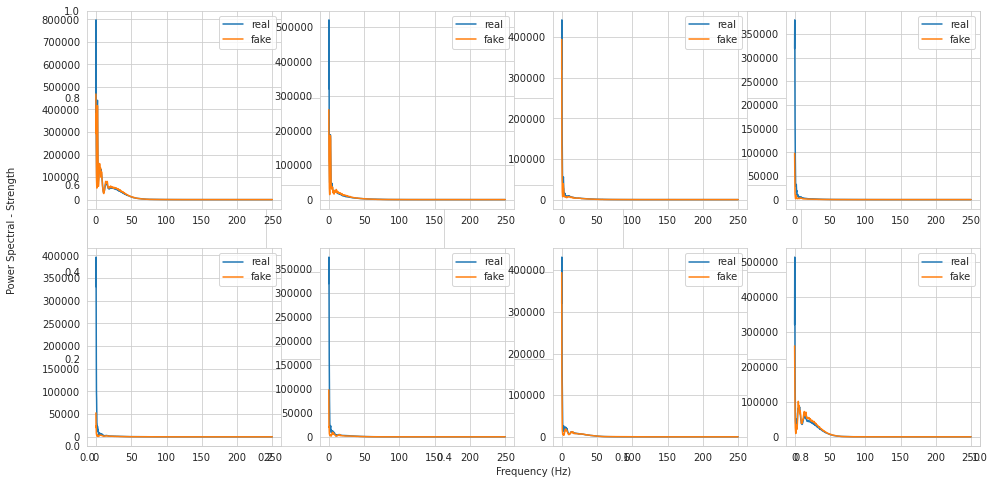

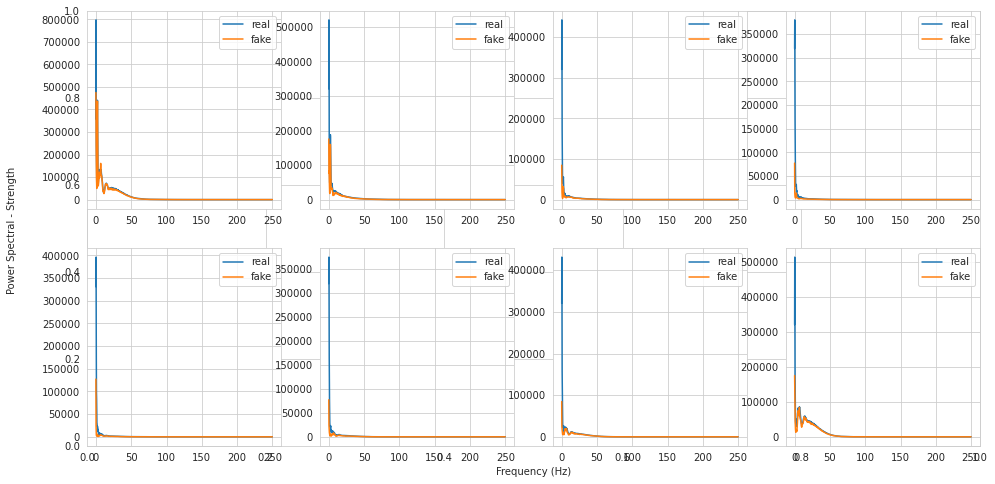

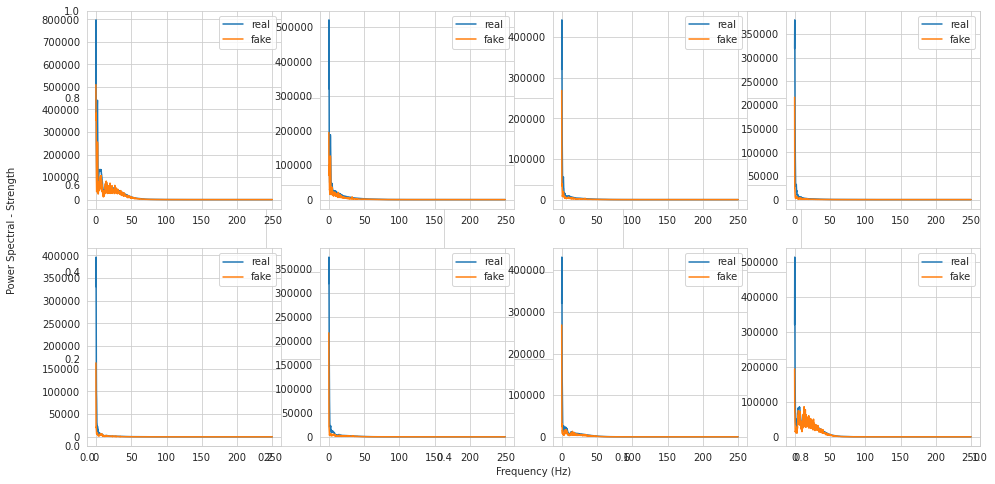

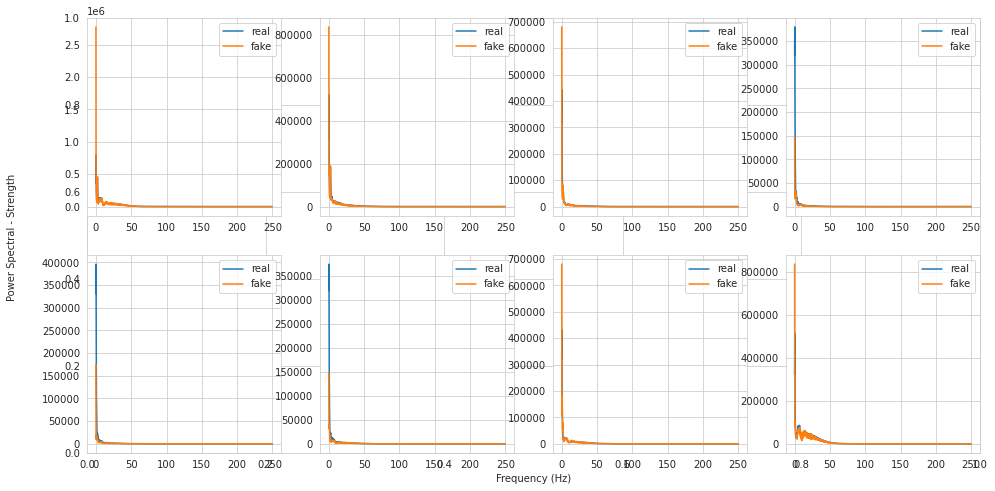

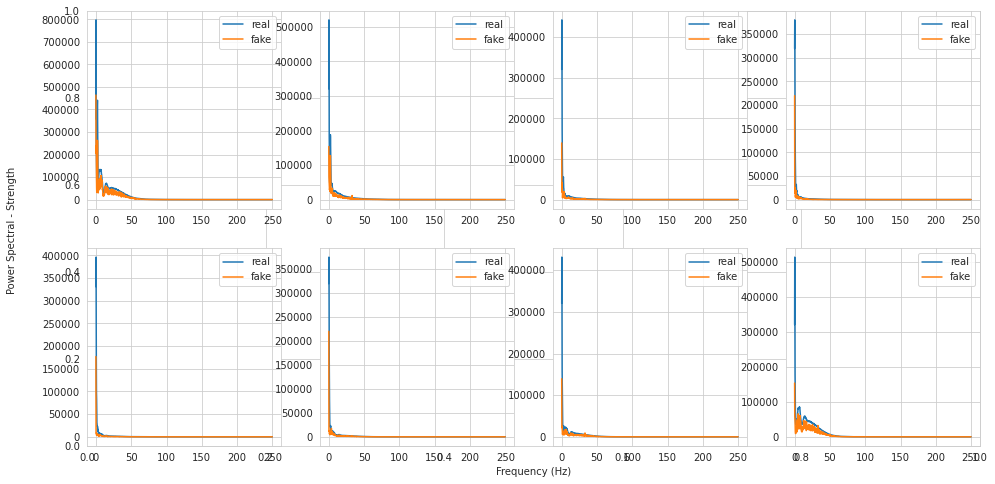

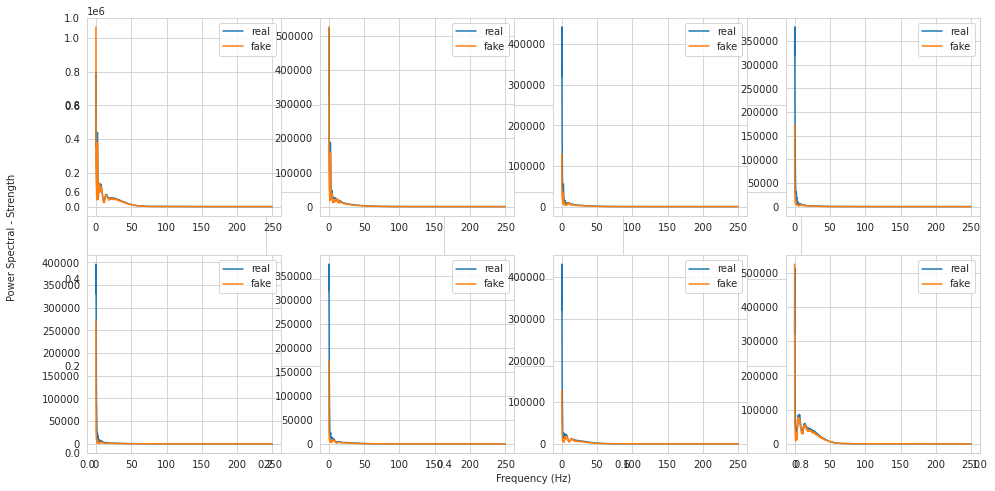

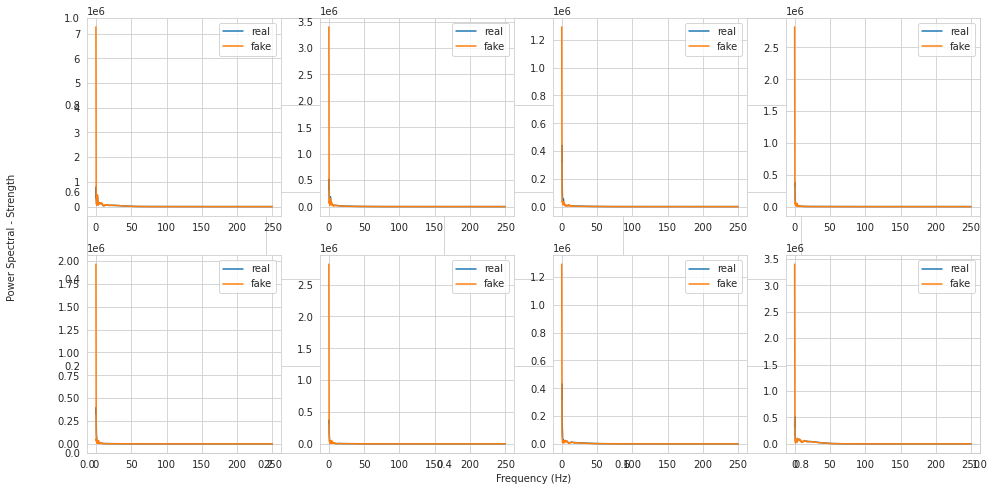

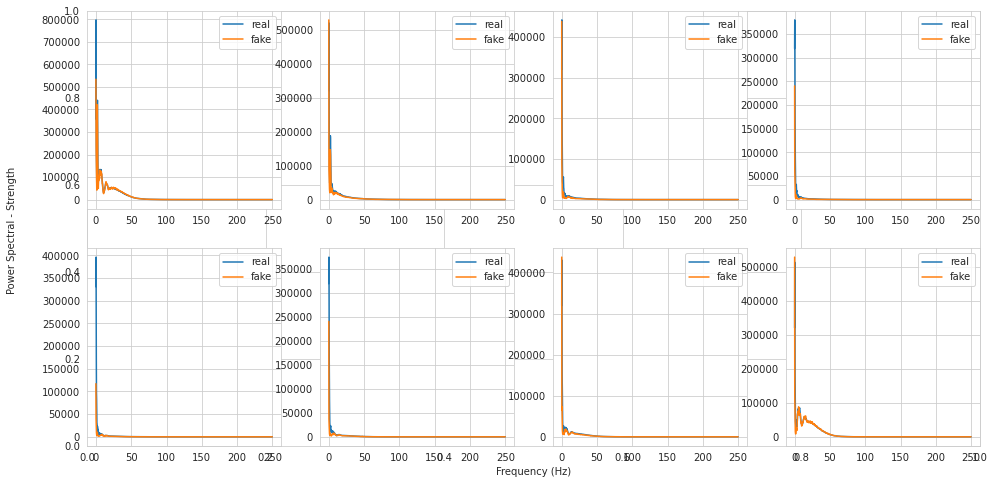

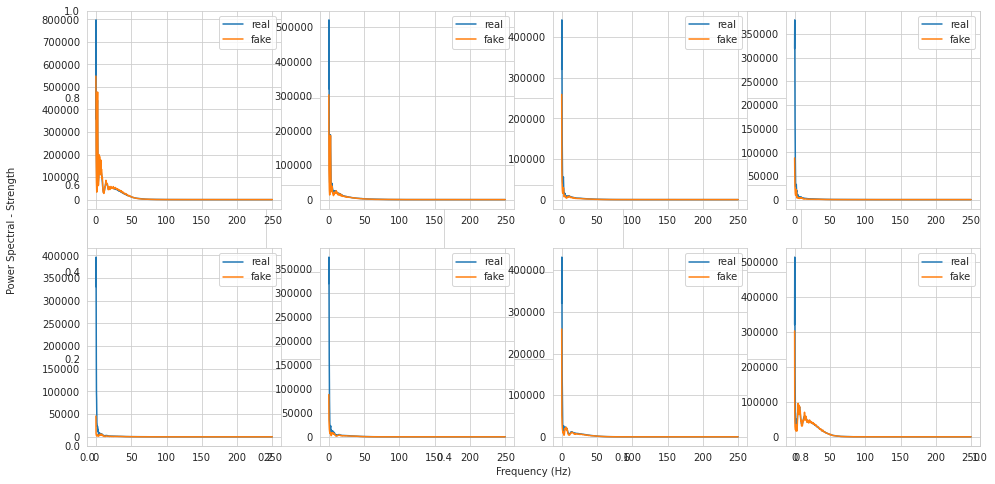

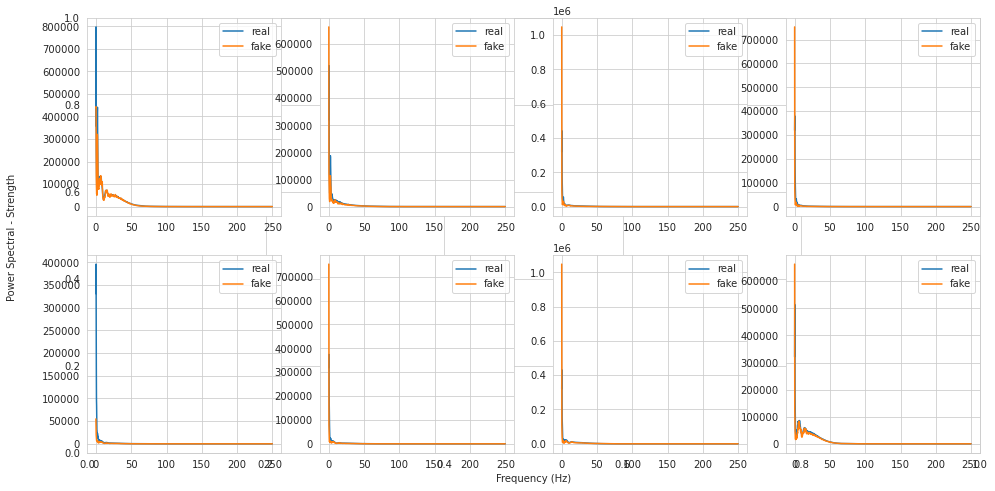

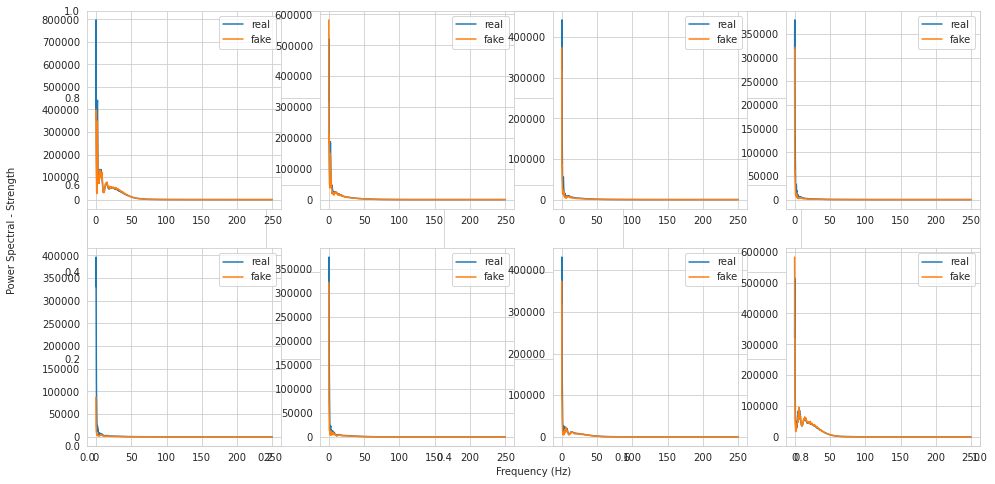

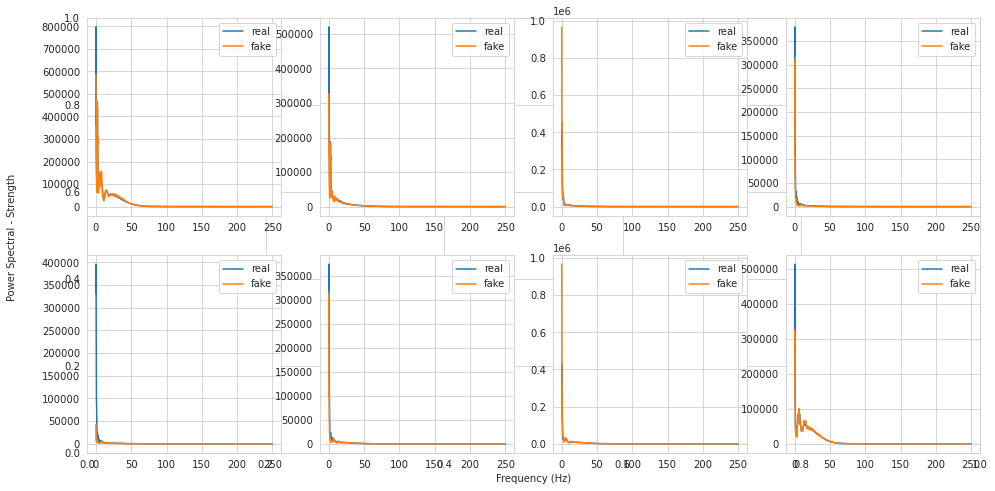

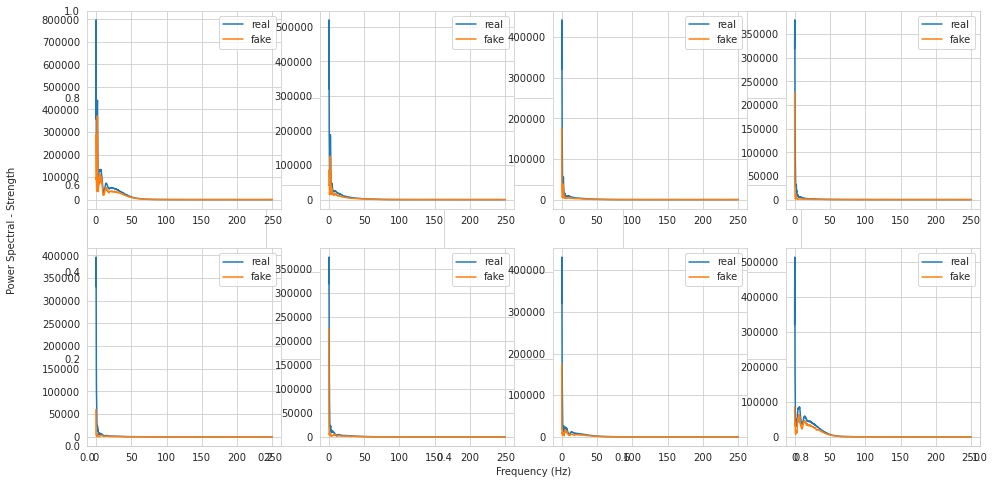

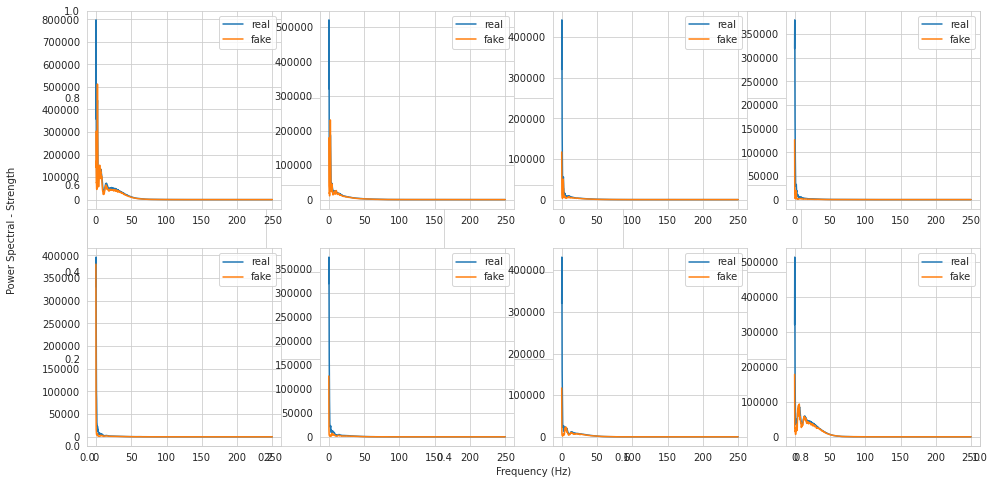

In [7]:
for m in ['cv2_ntf_auto', 'cv2_ntf', 'cv2_pos', 'cv2', 'cv2N']:
    for ch in range(1500, 2501, 500):
        path= f'/work/ramesh/final_experiment/fft/GAN/{m}/{m}_{ch}.pt'
        fake_ftp = load_gan(path)
        fpt_plot_v2(real_ftp, fake_ftp, 'gan', m, ch)

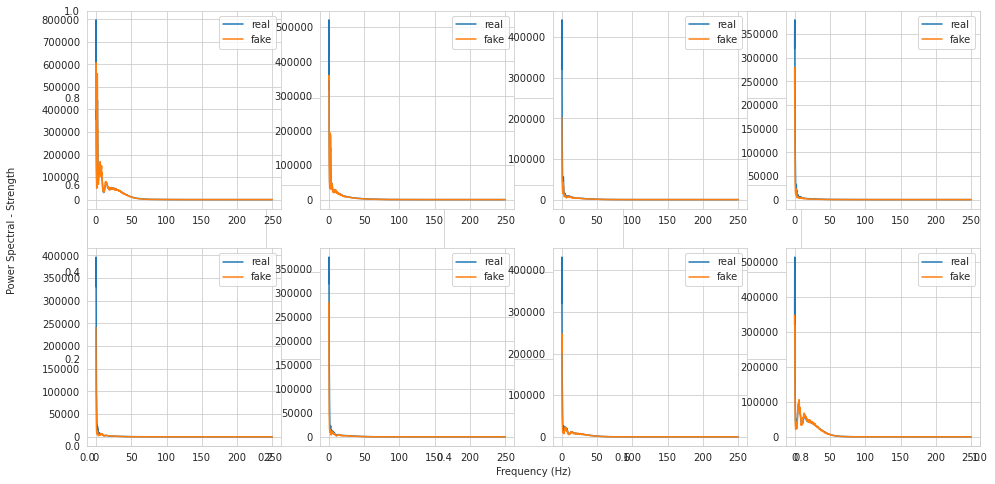

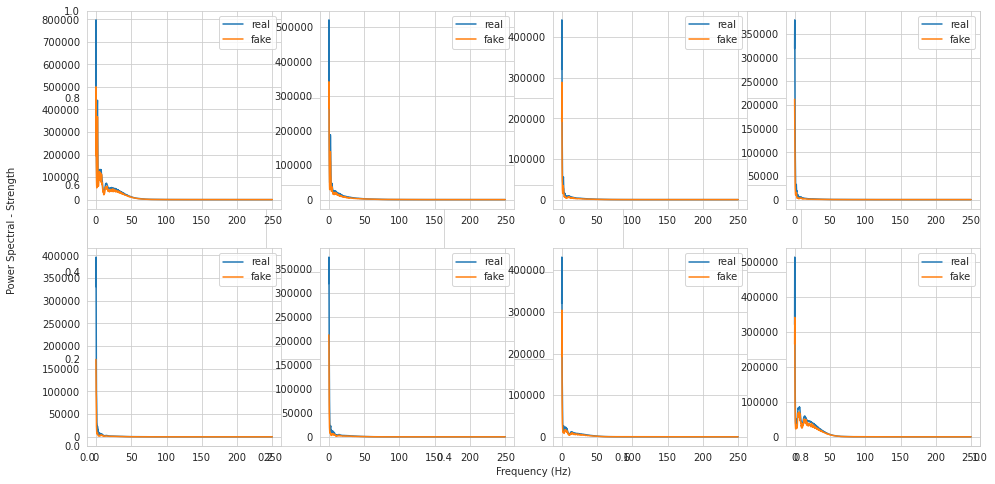

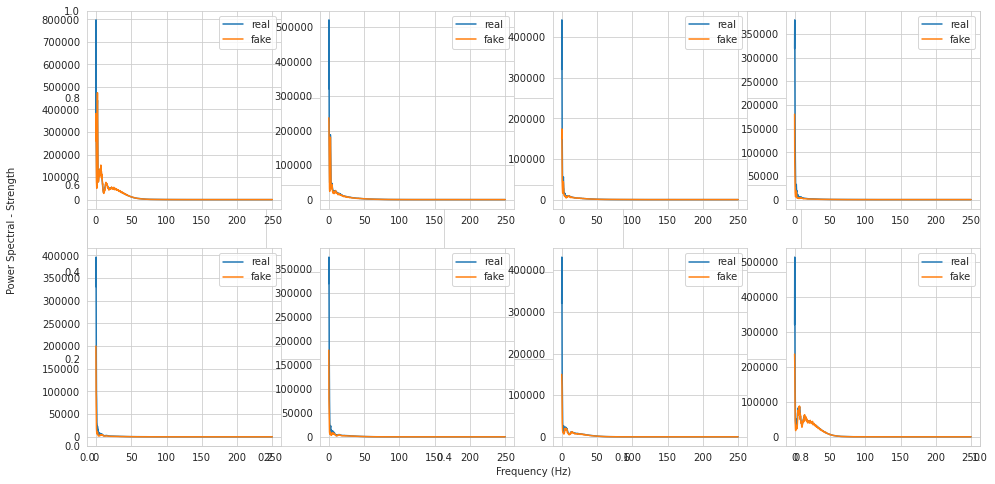

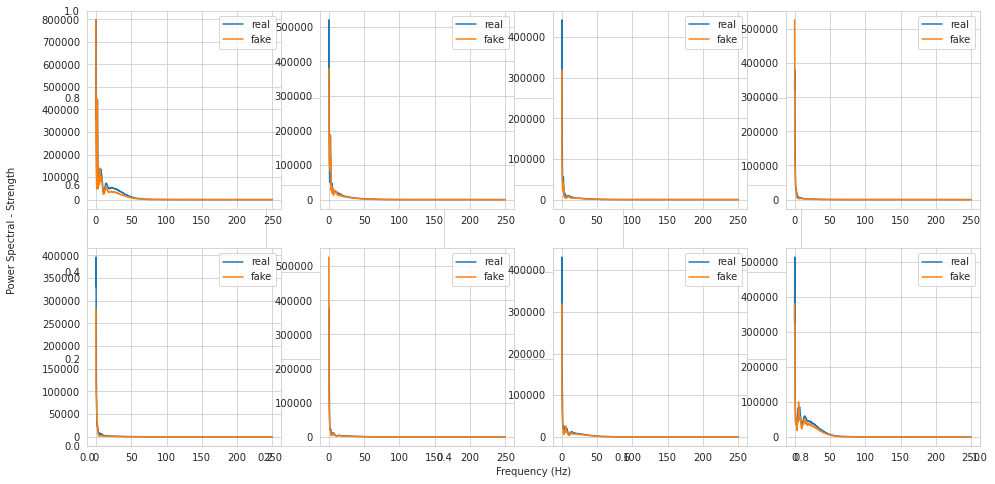

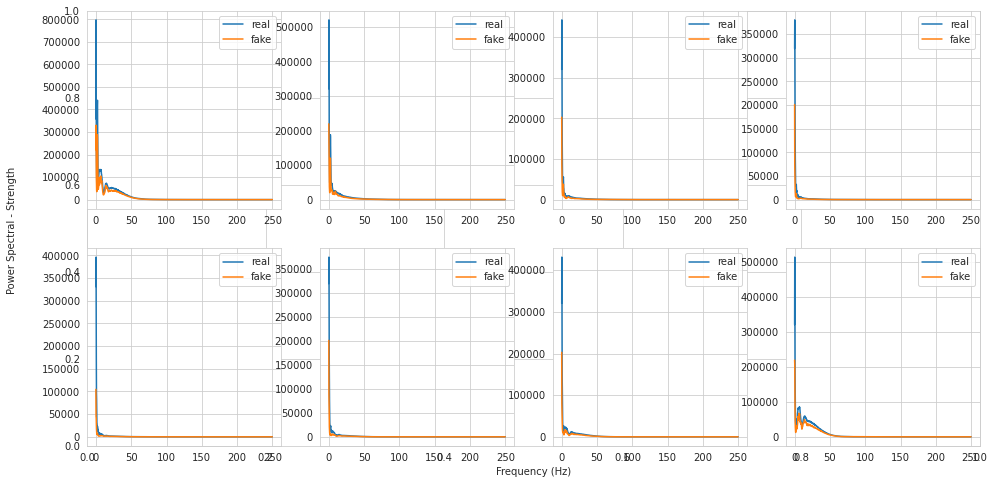

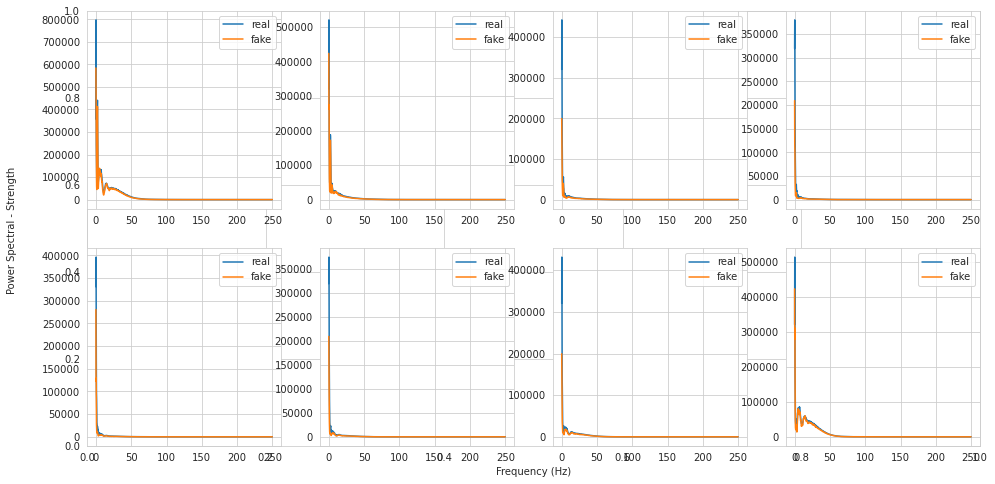

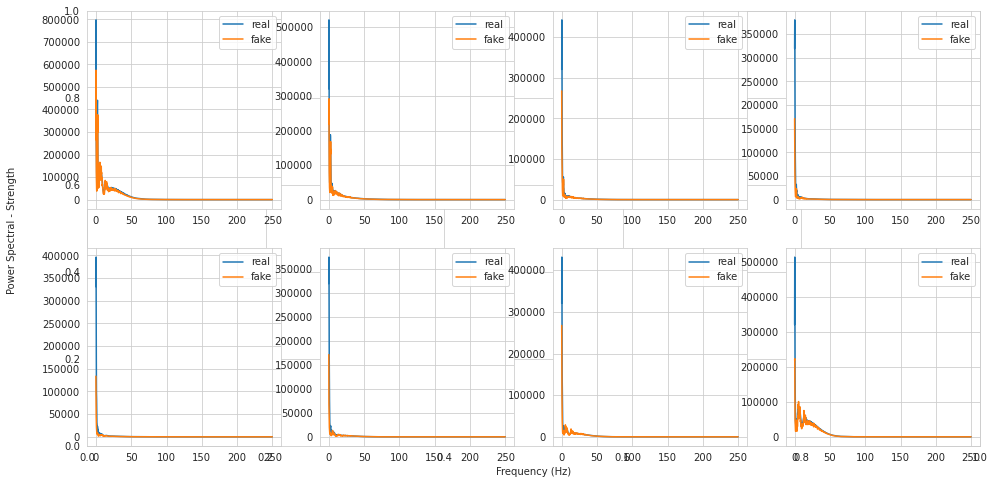

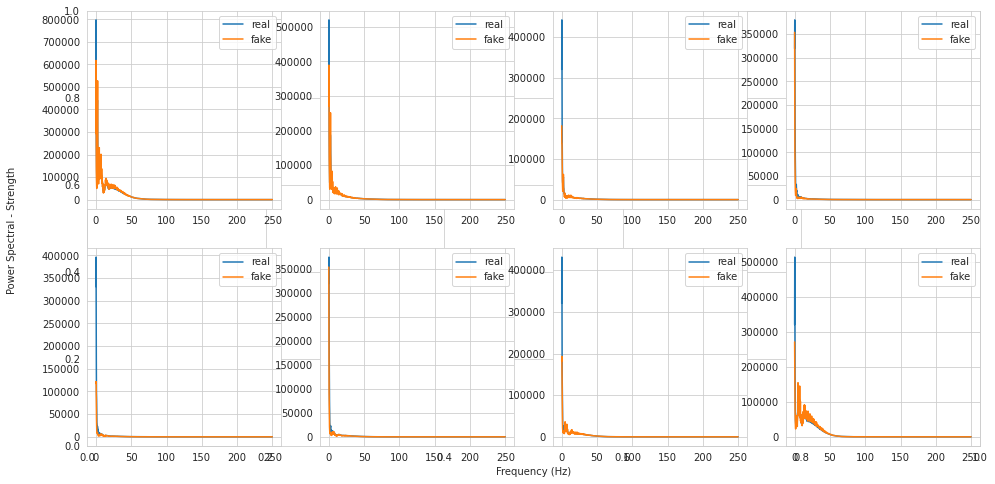

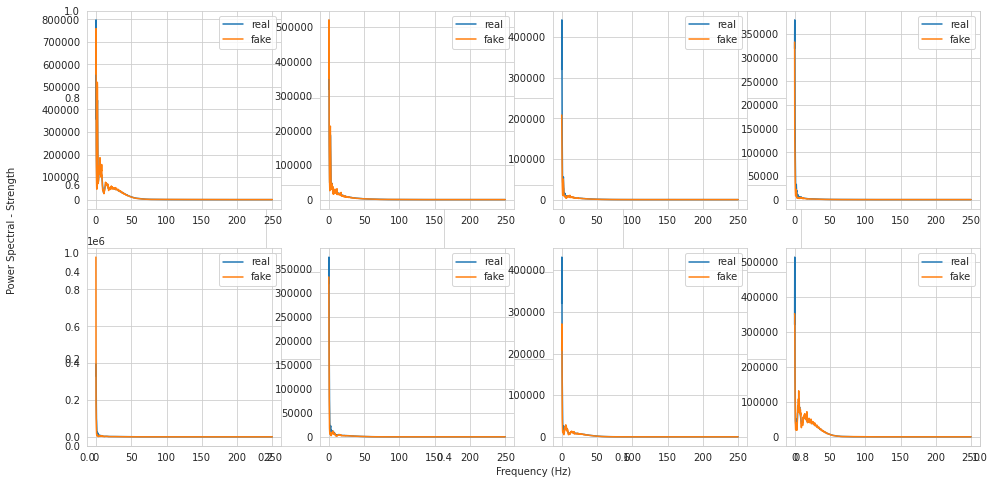

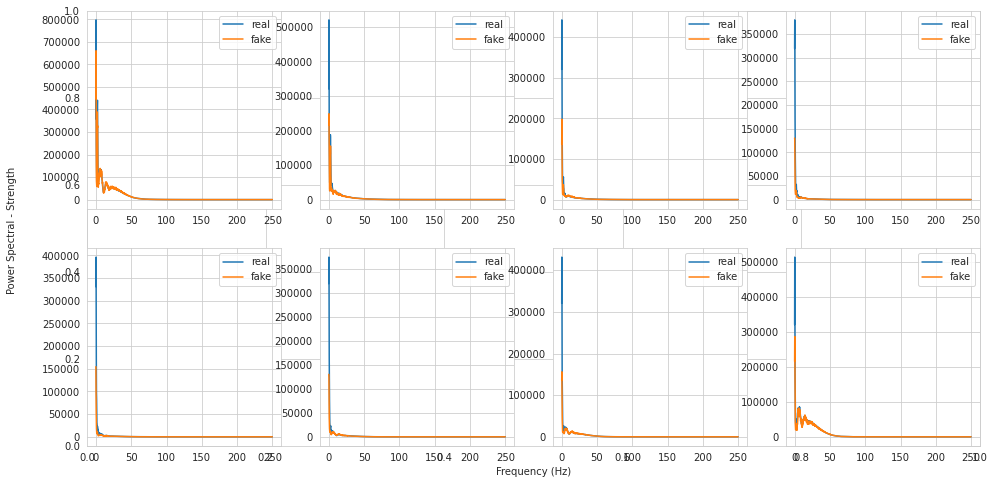

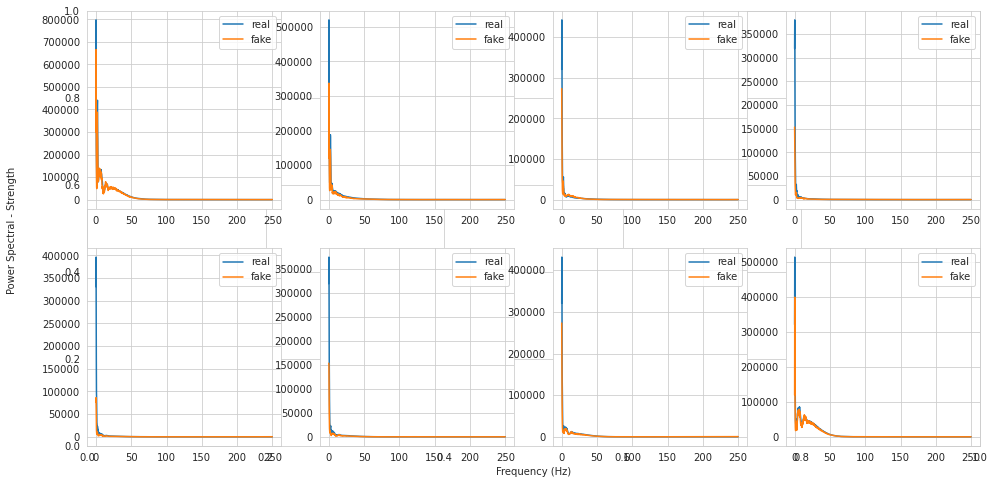

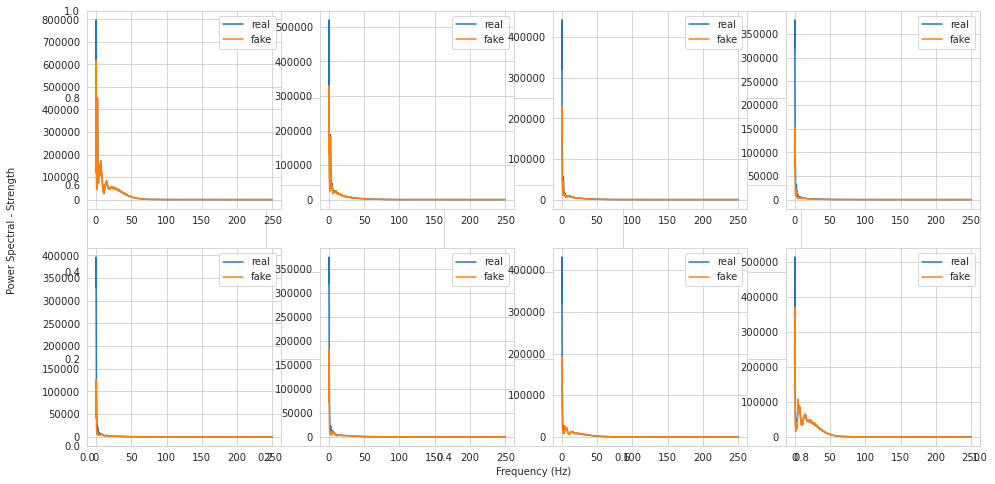

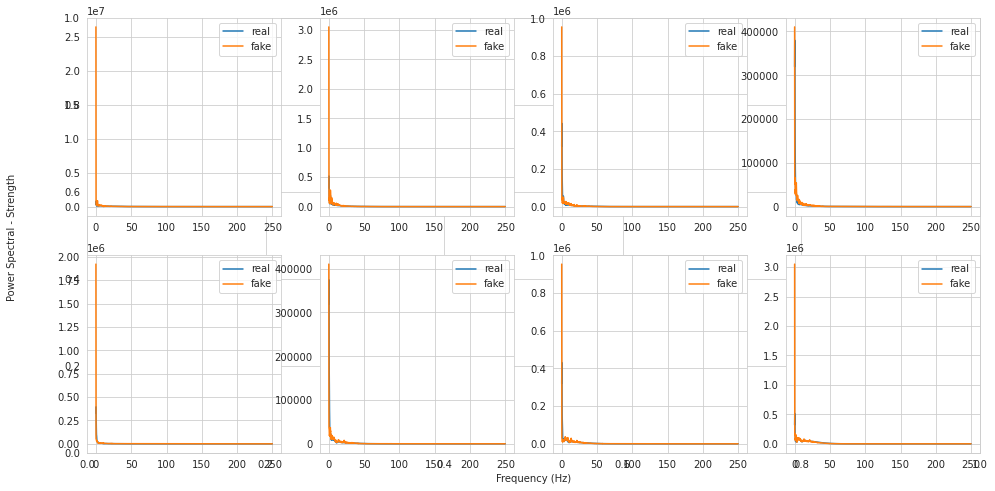

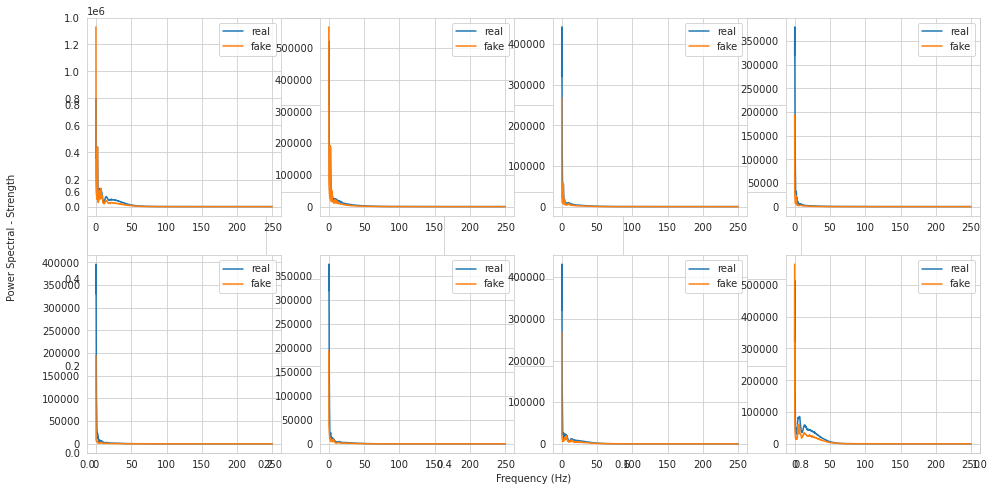

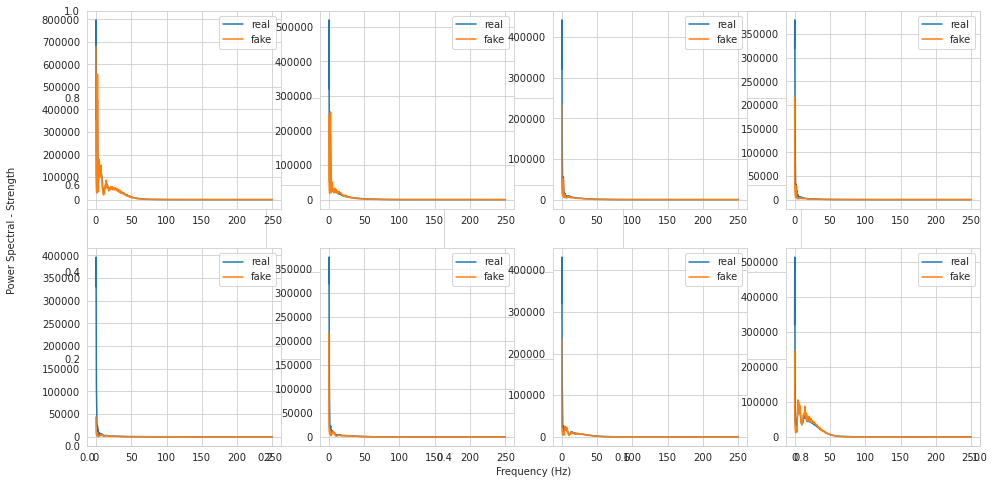

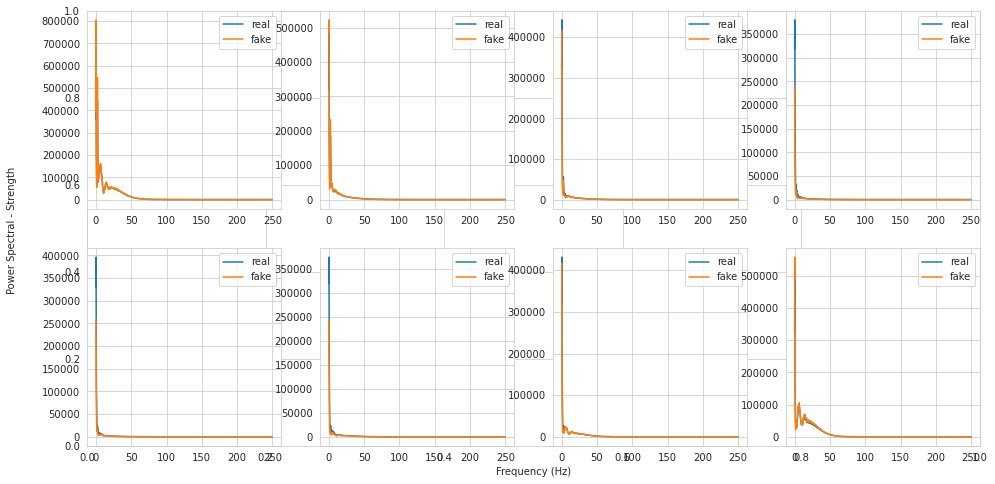

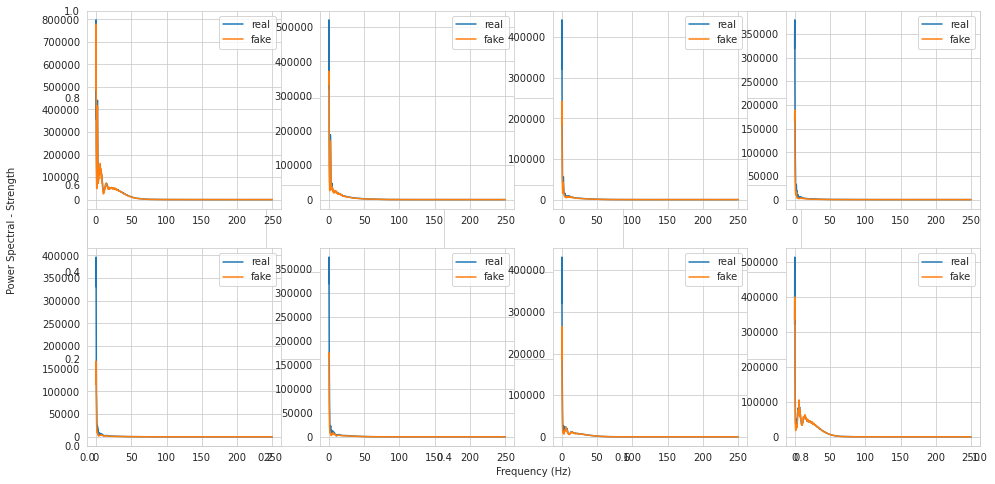

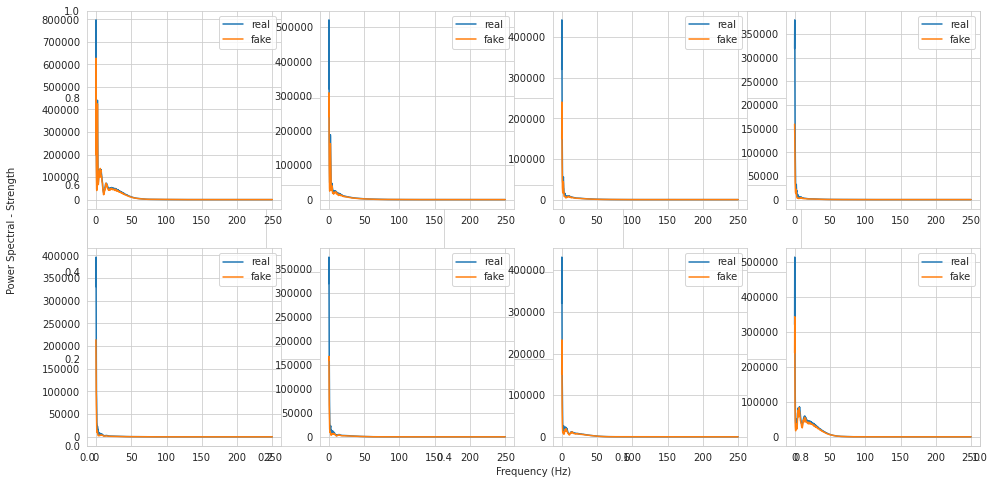

In [8]:
for m in ['v2_auto_re', 'v2_ntf_re', 'v2_pos_re', 'v2_re', 'v2N_re','v2_ntf_auto_re']:
    for ch in range(1500, 2501, 500):
        path= f'/work/ramesh/final_experiment/fft/unGAN/{m}/{m}_{ch}.pt'
        fake_ftp = load_gan(path)
        fpt_plot_v2(real_ftp, fake_ftp, 'ungan', m, ch)

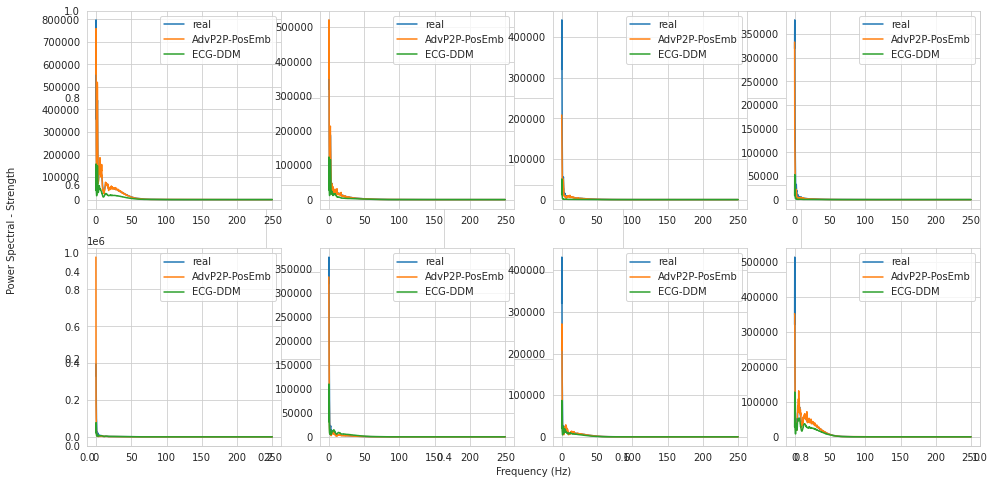

In [6]:
real = real_ftp
m = 'v2_pos_re'
ch=2500
path= f'/work/ramesh/final_experiment/fft/unGAN/{m}/{m}_{ch}.pt'
fake_gan = load_gan(path)

m = 'cddm'
ch = 174
path= f'/work/ramesh/final_experiment/fft/{m}/{m}_{ch}.pt'
fake_dif = load_diffusion(path)


time_step = 1/500 
freqs = np.fft.rfftfreq(real_ftp.shape[1], time_step)
idx = np.argsort(freqs)

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(111)

ax1 = fig.add_subplot(241)
ch = real[0::8, :].mean(axis=0)
ax1.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[0::8, :].mean(axis=0)
ax1.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[0::8, :].mean(axis=0)
ax1.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax1.legend()

ax2 = fig.add_subplot(242)
ch = real[1::8, :].mean(axis=0)
ax2.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[1::8, :].mean(axis=0)
ax2.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[1::8, :].mean(axis=0)
ax2.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax2.legend()

ax3 = fig.add_subplot(243)
ch = real[2::8, :].mean(axis=0)
ax3.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[2::8, :].mean(axis=0)
ax3.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[2::8, :].mean(axis=0)
ax3.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax3.legend()

ax4 = fig.add_subplot(244)
ch = real[3::8, :].mean(axis=0)
ax4.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[3::8, :].mean(axis=0)
ax4.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[3::8, :].mean(axis=0)
ax4.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax4.legend()

ax5 = fig.add_subplot(245)
ch = real[4::8, :].mean(axis=0)
ax5.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[4::8, :].mean(axis=0)
ax5.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[4::8, :].mean(axis=0)
ax5.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax5.legend()

ax6 = fig.add_subplot(246)
ch = real[5::8, :].mean(axis=0)
ax6.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[5::8, :].mean(axis=0)
ax6.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[5::8, :].mean(axis=0)
ax6.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax6.legend()

ax7 = fig.add_subplot(247)
ch = real[6::8, :].mean(axis=0)
ax7.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[6::8, :].mean(axis=0)
ax7.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[6::8, :].mean(axis=0)
ax7.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax7.legend()

ax8 = fig.add_subplot(248)
ch = real[7::8, :].mean(axis=0)
ax8.plot(freqs[idx], ch.flatten()[idx], label='real')
ch_f = fake_gan[7::8, :].mean(axis=0)
ax8.plot(freqs[idx], ch_f.flatten()[idx], label='AdvP2P-PosEmb')
ch_d = fake_dif[7::8, :].mean(axis=0)
ax8.plot(freqs[idx], ch_d.flatten()[idx], label='ECG-DDM')
ax8.legend() 
ax.set_xlabel('Frequency (Hz)')
fig.text(0.06, 0.5, 'Power Spectral - Strength', ha='center', va='center', rotation='vertical')
plt.savefig(f'./graphs/v2_pos_vs_cddm.jpeg')